In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/synprivutil-main

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/synprivutil-main


In [2]:
!pip install numpy==1.26.4 pandas==2.2.2 sdv==1.15.0 scikit-learn==1.5.1 seaborn==0.12.2 matplotlib==3.9.2 rdt==1.12.3 anonymeter==1.0.0 scipy==1.13.0 dython==0.7.8 POT==0.9.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/

## ML utility

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def calculate_ml_utility_classification(original, synthetic, target_column):
    """
    Evaluate machine learning utility by linking synthetic data to original data
    using classification models and calculating average F1 score and accuracy.

    Parameters:
        original (pd.DataFrame): Original dataset.
        synthetic (pd.DataFrame): Synthetic dataset.
        target_column (str): The target column for classification.

    Returns:
        dict: Average F1 score and accuracy for STO scenario across multiple classifiers.
    """
    # Step 1: Prepare original data
    X_test_orig = original.drop(columns=[target_column])
    y_test_orig = original[target_column]

    # Step 2: Prepare synthetic data
    X_syn = synthetic.drop(columns=[target_column])
    y_syn = synthetic[target_column]

    # Classification models
    models = [RandomForestClassifier(), GradientBoostingClassifier()]

    # Collect scores for STO (Train on Synthetic, Test on Original)
    sto_f1_list = []
    sto_accuracy_list = []

    for model in models:
        # Train on synthetic data, test on original data
        model.fit(X_syn, y_syn)
        y_pred_syn_on_orig = model.predict(X_test_orig)

        # Calculate F1 score and accuracy
        sto_f1 = f1_score(y_test_orig, y_pred_syn_on_orig, average='weighted')
        sto_accuracy = accuracy_score(y_test_orig, y_pred_syn_on_orig)

        sto_f1_list.append(sto_f1)
        sto_accuracy_list.append(sto_accuracy)

    # Average scores
    avg_sto_f1 = np.mean(sto_f1_list)
    avg_sto_accuracy = np.mean(sto_accuracy_list)

    metrics = {
        "F1_syn": avg_sto_f1,  # Train on synthetic, test on original
        "Accuracy_syn": avg_sto_accuracy  # Train on synthetic, test on original
    }

    return metrics


In [3]:
def replace_outliers_with_mean(original_data, synthetic_data, threshold=1):

    for column in synthetic_data.columns:
        if column in original_data.columns:
            # Use max and min with std range to determine abnormal value
            orig_mean = original_data[column].median()
            orig_max = original_data[column].max()
            orig_min = original_data[column].min()
            orig_std = original_data[column].std()

            lower_bound = orig_min - threshold * orig_std
            upper_bound = orig_max + threshold * orig_std

            synthetic_data[column] = synthetic_data[column].apply(
                lambda x: orig_mean if x < lower_bound or x > upper_bound else x
            )
            # print(f"Column '{column}': replaced outliers outside [{lower_bound}, {upper_bound}] with mean ({orig_mean}).")

    return synthetic_data

def remove_rows_with_outliers(original_data, synthetic_data, synthetic_name, threshold=1):
   
    rows_to_drop = set()

    for column in synthetic_data.columns:
        if column in original_data.columns:
            
            orig_mean = original_data[column].median()
            orig_max = original_data[column].max()
            orig_min = original_data[column].min()
            orig_std = original_data[column].std()

            lower_bound = orig_min - threshold * orig_std
            upper_bound = orig_max + threshold * orig_std

            outlier_indices = synthetic_data[(synthetic_data[column] < lower_bound) |
                                             (synthetic_data[column] > upper_bound)].index
            rows_to_drop.update(outlier_indices)

    rows_to_drop = list(rows_to_drop)  
    cleaned_data = synthetic_data.drop(index=rows_to_drop)

    print(f"Under {synthetic_name}, removed {len(rows_to_drop)} rows with outliers.")
    return cleaned_data

In [23]:
import os
import re
import gc
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/diabetes-test.csv")
original_name = "diabetes"

# Directory containing synthetic datasets
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/diabetes_syn_data"

# Dictionary to store aggregated results
aggregated_results = defaultdict(lambda: defaultdict(list))

# Function to extract sigma value as float
def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
    return None

target_column = "Outcome"  # Replace with your actual target column
task_type = "classification"  # "classification" or "regression"

# Loop through each synthetic file and perform calculations
for file_name in os.listdir(synthetic_folder):
    if file_name.endswith(".csv"):
        synthetic_path = os.path.join(synthetic_folder, file_name)
        synthetic_data = pd.read_csv(synthetic_path)

        # Ensure correct data types (e.g., convert 'age' column to int if needed)
        for column in synthetic_data.columns:
            if column in original_data.columns:
                # Convert the column type in synthetic data to match the original data
                synthetic_data[column] = synthetic_data[column].astype(original_data[column].dtype)

        # synthetic_data = replace_outliers_with_mean(original_data, synthetic_data)
        synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, file_name)
        sigma = extract_sigma(file_name)
        if sigma is None:
            continue  # Skip files without a valid sigma value
        # print(f"\nProcessing synthetic dataset: {file_name} (sigma: {sigma})")

        # Step 1: Calculate ML utility
        ml_results = calculate_ml_utility_classification(original_data, synthetic_data, target_column)

        # Step 2: Add metrics to aggregated_results
        for category, metric_value in ml_results.items():
            aggregated_results[sigma][category].append(metric_value)

        # Cleanup
        del synthetic_data
        gc.collect()



# Step 3: Calculate average metrics for each sigma
averaged_results = defaultdict(dict)
for sigma, metrics in aggregated_results.items():
    for metric, values in metrics.items():
        averaged_results[sigma][metric] = np.mean(values)

# Step 4: Convert averaged_results into a DataFrame
final_results = defaultdict(list)
for sigma, metrics in averaged_results.items():
    final_results["sigma"].append(sigma)
    for metric, value in metrics.items():
        final_results[metric].append(value)

df = pd.DataFrame(final_results)

# Sort the DataFrame by sigma
df = df.sort_values(by="sigma").reset_index(drop=True)

# Step 5: Print and verify the DataFrame
print(df)


Under diabetes-sigma-001.csv, removed 11 rows with outliers.
Under diabetes-sigma-005.csv, removed 29 rows with outliers.
Under diabetes-sigma-010.csv, removed 56 rows with outliers.
Under diabetes-sigma-015.csv, removed 95 rows with outliers.
Under diabetes-sigma-020.csv, removed 117 rows with outliers.
Under diabetes-sigma-025.csv, removed 137 rows with outliers.
Under diabetes-sigma-030.csv, removed 149 rows with outliers.
Under diabetes-sigma-035.csv, removed 145 rows with outliers.
Under diabetes-sigma-040.csv, removed 152 rows with outliers.
Under diabetes-sigma-045.csv, removed 207 rows with outliers.
Under diabetes-switch-sigma-015.csv, removed 43 rows with outliers.
Under diabetes-sigma-002.csv, removed 26 rows with outliers.
Under diabetes-sigma-003.csv, removed 33 rows with outliers.
Under diabetes-sigma-004.csv, removed 23 rows with outliers.
Under diabetes-sigma-0.csv, removed 11 rows with outliers.
    sigma    F1_syn  Accuracy_syn
0    0.00  0.703249      0.701299
1    0

## Privacy and utility evaluations

### original

In [5]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.utility_metric_manager import UtilityMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.basic_stats import BasicStatsCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.mutual_information import MICalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.correlation import CorrelationCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.js_similarity import JSCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.privacy_metric_manager import PrivacyMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.adversarial_accuracy_class import AdversarialAccuracyCalculator, AdversarialAccuracyCalculator_NN
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.dcr_class import DCRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.nndr_class import NNDRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.disco import DisclosureCalculator

# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/diabetes.csv")
original_name = "Insurance"

# Directory containing synthetic datasets
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/diabetes_syn_data"

# Dictionary to store aggregated results
aggregated_results = defaultdict(lambda: defaultdict(list))

# Function to extract sigma value as float
def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
    return None


# Loop through each synthetic file and perform calculations
for file_name in os.listdir(synthetic_folder):
    if file_name.endswith(".csv"):
        synthetic_path = os.path.join(synthetic_folder, file_name)
        synthetic_data = pd.read_csv(synthetic_path)
        # synthetic_data = replace_outliers_with_mean(original_data, synthetic_data)
        # synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, file_name)
        # Ensure correct data types (e.g., convert 'age' column to int if needed)
        # if 'Glucose' in synthetic_data.columns:
        #     synthetic_data['Glucose'] = synthetic_data['Glucose'].astype(int)
        # if 'BloodPressure' in synthetic_data.columns:
        #     synthetic_data['BloodPressure'] = synthetic_data['BloodPressure'].astype(int)
        for column in synthetic_data.columns:
            if column in original_data.columns:
                # Convert the column type in synthetic data to match the original data
                synthetic_data[column] = synthetic_data[column].astype(original_data[column].dtype)


        sigma = extract_sigma(file_name)
        if sigma is None:
            continue  # Skip files without a valid sigma value
        # print(f"\nProcessing synthetic dataset: {file_name} (sigma: {sigma})")

        # Utility Metric Calculation
        u = UtilityMetricManager()
        utility_metric_list = [
            BasicStatsCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            MICalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            CorrelationCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            JSCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        u.add_metric(utility_metric_list)
        results_utility = u.evaluate_all()

        # Privacy Metric Calculation
        p = PrivacyMetricManager()
        privacy_metric_list = [
            DCRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            NNDRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator_NN(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        p.add_metric(privacy_metric_list)
        results_privacy = p.evaluate_all()

        # # DiSCO and repU
        diabetes_keys = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
        diabetes_target = 'Outcome'     

        calc = DisclosureCalculator(original_data, synthetic_data, keys=diabetes_keys, target=diabetes_target)
        repU, DiSCO = calc.evaluate()

        # Aggregate metrics
        for key, value in {**results_utility, **results_privacy}.items():
            aggregated_results[sigma][key].append(value)


        aggregated_results[sigma]["Disclosure_repU"].append(repU)
        aggregated_results[sigma]["Disclosure_DiSCO"].append(DiSCO)

# Calculate average metrics for each sigma
averaged_results = defaultdict(dict)
for sigma, metrics in aggregated_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):
            averaged_results[sigma][metric] = {k: np.mean([v[k] for v in values]) for k in values[0]}
        else:
            averaged_results[sigma][metric] = np.mean(values)

Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 166.80it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1087 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO        UiS     UiOiS      repU
0  100.0  74.529667  35.15625  25.78125
ATTRIBUTES: 
   Dorig       Dsyn        iS        DiS      DiSCO     DiSDiO  max_denom  \
0  100.0  92.908828  35.15625  32.682292  28.385417  28.385417        1.0   

   mean_denom  
0         1.0  
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 153.10it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1459 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 148.43it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1455 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 144.64it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1452 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 128.89it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1454 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 145.53it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1432 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 132.56it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1435 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 136.60it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1428 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 147.86it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1405 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 130.06it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1403 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 138.38it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1386 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 144.33it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1447 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 145.02it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1458 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 154.27it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1457 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 142.26it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1457 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~


In [9]:
# Clean up averaged_results to extract metric names without file details
cleaned_results = defaultdict(dict)

for sigma, metrics in averaged_results.items():
    for metric, value in metrics.items():
        # Extract only the metric name, ignoring dataset/file info
        metric_name = metric.split("(")[0]
        if metric_name not in cleaned_results[sigma]:
            cleaned_results[sigma][metric_name] = []
        cleaned_results[sigma][metric_name].append(value)

# Aggregate and calculate average values for cleaned results
final_results = defaultdict(dict)
for sigma, metrics in cleaned_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):  # If metric value is a dictionary
            # Average each key in the dictionary
            final_results[sigma][metric] = {k: sum(v[k] for v in values) / len(values) for k in values[0]}
        else:  # If metric value is a list of scalars
            final_results[sigma][metric] = sum(values) / len(values)

# Prepare data for plotting
data = {
    "sigma": sorted(final_results.keys()),
    "DCR": [final_results[sigma].get("DCRCalculator", None) for sigma in sorted(final_results.keys())],
    "NNDR": [final_results[sigma].get("NNDRCalculator", None) for sigma in sorted(final_results.keys())],
    # "AdversarialAccuracy": [final_results[sigma].get("AdversarialAccuracyCalculator", None) for sigma in sorted(final_results.keys())],
    "NNAA": [final_results[sigma].get("AdversarialAccuracyCalculator_NN", None) for sigma in sorted(final_results.keys())],
    "Correlation": [final_results[sigma].get("CorrelationCalculator", None) for sigma in sorted(final_results.keys())],
    "JS": [final_results[sigma].get("JSCalculator", None) for sigma in sorted(final_results.keys())],
    "repU": [final_results[sigma].get("Disclosure_repU", None) for sigma in sorted(final_results.keys())],
    "DiSCO": [final_results[sigma].get("Disclosure_DiSCO", None) for sigma in sorted(final_results.keys())],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Verify DataFrame content
print(df)


    sigma       DCR      NNDR      NNAA  Correlation        JS      repU  \
0    0.00  0.076270  0.395513  0.228899     0.984228  0.920506  25.78125   
1    0.01  0.174328  0.852604  0.656199     0.956929  0.858296   0.00000   
2    0.02  0.189132  0.854679  0.701834     0.939083  0.844859   0.00000   
3    0.03  0.241994  0.867540  0.804280     0.933835  0.813594   0.00000   
4    0.04  0.222412  0.865663  0.754826     0.930091  0.831563   0.00000   
5    0.05  0.327776  0.869826  0.800642     0.931720  0.820088   0.00000   
6    0.10  0.249920  0.870001  0.745568     0.925955  0.830506   0.00000   
7    0.15  0.851569  0.871882  0.746098     0.921306  0.828131   0.00000   
8    0.20  0.984395  0.870515  0.776363     0.919209  0.805522   0.00000   
9    0.25  0.306981  0.882570  0.795287     0.918539  0.782241   0.00000   
10   0.30  1.057973  0.880510  0.790080     0.918381  0.776048   0.00000   
11   0.35  1.120052  0.889042  0.803965     0.923184  0.771731   0.00000   
12   0.40  1

In [10]:

basic_stats_data = {
    "sigma": [],
    "mean": [],
    "median": [],
    "var": []
}

for sigma, metrics in final_results.items():
    if "BasicStatsCalculator" in metrics:
        basic_stats = metrics["BasicStatsCalculator"]
        basic_stats_data["sigma"].append(sigma)
        basic_stats_data["mean"].append(basic_stats["mean"])
        basic_stats_data["median"].append(basic_stats["median"])
        basic_stats_data["var"].append(basic_stats["var"])

basic_stats_df = pd.DataFrame(basic_stats_data)

print(basic_stats_df)


    sigma      mean    median        var
0    0.00  0.017840  0.019283   0.003327
1    0.01  0.040195  0.051677   0.007280
2    0.05  0.056724  0.080625   0.601312
3    0.10  0.036943  0.050698   0.022392
4    0.15  0.097369  0.058966  27.558255
5    0.20  0.114005  0.046786  33.151961
6    0.25  0.049040  0.050786   0.031498
7    0.30  0.095122  0.028093  30.627001
8    0.35  0.121532  0.045626  18.606398
9    0.40  0.126218  0.055350  31.845941
10   0.45  0.240880  0.060518  97.030922
11   0.02  0.042260  0.051657   0.006339
12   0.03  0.053478  0.082809   0.011515
13   0.04  0.035023  0.048015   0.011012


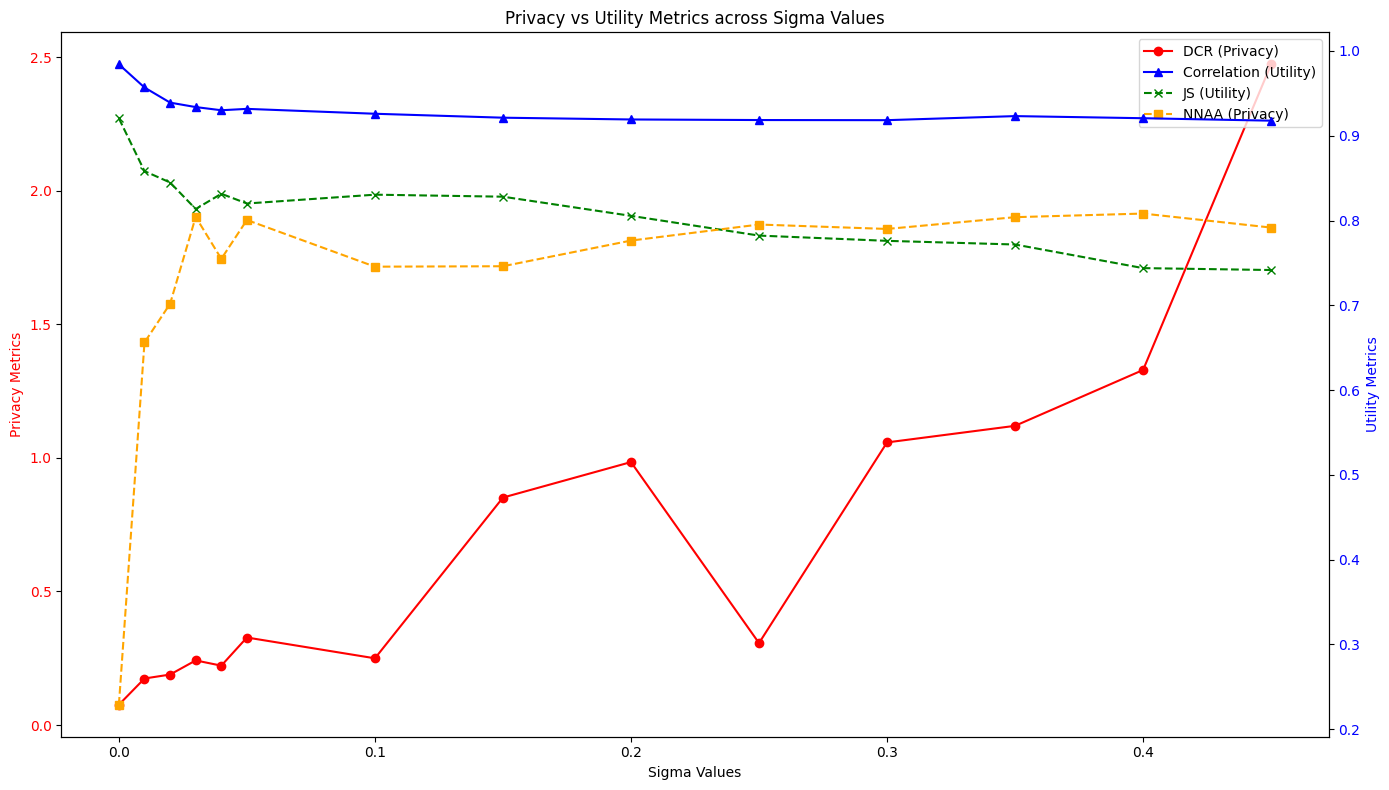

In [8]:
import matplotlib.pyplot as plt

datasets = df["sigma"]

DCR = df["DCR"]
adversarial_accuracy = df["NNAA"]

correlation = df["Correlation"]
JS = df["JS"]

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(datasets, DCR, marker='o', color='red', label="DCR (Privacy)", linestyle='-')
ax1.set_xlabel("Sigma Values")
ax1.set_ylabel("Privacy Metrics", color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(datasets, correlation, marker='^', color='blue', label="Correlation (Utility)", linestyle='-')
ax2.plot(datasets, JS, marker='x', color='green', label="JS (Utility)", linestyle='--')
ax2.plot(datasets, adversarial_accuracy, marker='s', color='orange', label="NNAA (Privacy)", linestyle='--')
ax2.set_ylabel("Utility Metrics", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Privacy vs Utility Metrics across Sigma Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### replace

In [11]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.utility_metric_manager import UtilityMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.basic_stats import BasicStatsCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.mutual_information import MICalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.correlation import CorrelationCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.js_similarity import JSCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.privacy_metric_manager import PrivacyMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.adversarial_accuracy_class import AdversarialAccuracyCalculator, AdversarialAccuracyCalculator_NN
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.dcr_class import DCRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.nndr_class import NNDRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.disco import DisclosureCalculator

# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/diabetes.csv")
original_name = "Insurance"

# Directory containing synthetic datasets
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/diabetes_syn_data"

# Dictionary to store aggregated results
aggregated_results = defaultdict(lambda: defaultdict(list))

# Function to extract sigma value as float
def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
    return None


# Loop through each synthetic file and perform calculations
for file_name in os.listdir(synthetic_folder):
    if file_name.endswith(".csv"):
        synthetic_path = os.path.join(synthetic_folder, file_name)
        synthetic_data = pd.read_csv(synthetic_path)
        synthetic_data = replace_outliers_with_mean(original_data, synthetic_data)
        # synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, file_name)
        # Ensure correct data types (e.g., convert 'age' column to int if needed)
        # if 'Glucose' in synthetic_data.columns:
        #     synthetic_data['Glucose'] = synthetic_data['Glucose'].astype(int)
        # if 'BloodPressure' in synthetic_data.columns:
        #     synthetic_data['BloodPressure'] = synthetic_data['BloodPressure'].astype(int)
        for column in synthetic_data.columns:
            if column in original_data.columns:
                # Convert the column type in synthetic data to match the original data
                synthetic_data[column] = synthetic_data[column].astype(original_data[column].dtype)


        sigma = extract_sigma(file_name)
        if sigma is None:
            continue  # Skip files without a valid sigma value
        # print(f"\nProcessing synthetic dataset: {file_name} (sigma: {sigma})")

        # Utility Metric Calculation
        u = UtilityMetricManager()
        utility_metric_list = [
            BasicStatsCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            MICalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            CorrelationCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            JSCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        u.add_metric(utility_metric_list)
        results_utility = u.evaluate_all()

        # Privacy Metric Calculation
        p = PrivacyMetricManager()
        privacy_metric_list = [
            DCRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            NNDRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator_NN(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        p.add_metric(privacy_metric_list)
        results_privacy = p.evaluate_all()

        # # DiSCO and repU
        diabetes_keys = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
        diabetes_target = 'Outcome'  

        calc = DisclosureCalculator(original_data, synthetic_data, keys=diabetes_keys, target=diabetes_target)
        repU, DiSCO = calc.evaluate()

        # Aggregate metrics
        for key, value in {**results_utility, **results_privacy}.items():
            aggregated_results[sigma][key].append(value)


        aggregated_results[sigma]["Disclosure_repU"].append(repU)
        aggregated_results[sigma]["Disclosure_DiSCO"].append(DiSCO)

# Calculate average metrics for each sigma
averaged_results = defaultdict(dict)
for sigma, metrics in aggregated_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):
            averaged_results[sigma][metric] = {k: np.mean([v[k] for v in values]) for k in values[0]}
        else:
            averaged_results[sigma][metric] = np.mean(values)

Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 149.35it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1087 columns.
IDENTITY: 
     UiO        UiS     UiOiS      repU
0  100.0  74.529667  35.15625  25.78125
ATTRIBUTES: 
   Dorig       Dsyn        iS        DiS      DiSCO     DiSDiO  max_denom  \
0  100.0  92.908828  35.15625  32.682292  28.385417  28.385417        1.0   

   mean_denom  
0         1.0  
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 150.40it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1459 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 147.89it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1455 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 142.29it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1452 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 136.12it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1454 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 136.61it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1432 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 140.18it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1435 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 151.09it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1428 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 148.23it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1405 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 146.57it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1403 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 145.23it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1386 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 136.21it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1447 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 146.68it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1458 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 152.75it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1457 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 140.30it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1457 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~


In [12]:
# Clean up averaged_results to extract metric names without file details
cleaned_results = defaultdict(dict)

for sigma, metrics in averaged_results.items():
    for metric, value in metrics.items():
        # Extract only the metric name, ignoring dataset/file info
        metric_name = metric.split("(")[0]
        if metric_name not in cleaned_results[sigma]:
            cleaned_results[sigma][metric_name] = []
        cleaned_results[sigma][metric_name].append(value)

# Aggregate and calculate average values for cleaned results
final_results = defaultdict(dict)
for sigma, metrics in cleaned_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):  # If metric value is a dictionary
            # Average each key in the dictionary
            final_results[sigma][metric] = {k: sum(v[k] for v in values) / len(values) for k in values[0]}
        else:  # If metric value is a list of scalars
            final_results[sigma][metric] = sum(values) / len(values)

# Prepare data for plotting
data = {
    "sigma": sorted(final_results.keys()),
    "DCR": [final_results[sigma].get("DCRCalculator", None) for sigma in sorted(final_results.keys())],
    "NNDR": [final_results[sigma].get("NNDRCalculator", None) for sigma in sorted(final_results.keys())],
    # "AdversarialAccuracy": [final_results[sigma].get("AdversarialAccuracyCalculator", None) for sigma in sorted(final_results.keys())],
    "NNAA": [final_results[sigma].get("AdversarialAccuracyCalculator_NN", None) for sigma in sorted(final_results.keys())],
    "Correlation": [final_results[sigma].get("CorrelationCalculator", None) for sigma in sorted(final_results.keys())],
    "JS": [final_results[sigma].get("JSCalculator", None) for sigma in sorted(final_results.keys())],
    "repU": [final_results[sigma].get("Disclosure_repU", None) for sigma in sorted(final_results.keys())],
    "DiSCO": [final_results[sigma].get("Disclosure_DiSCO", None) for sigma in sorted(final_results.keys())],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Verify DataFrame content
print(df)


    sigma       DCR      NNDR      NNAA  Correlation        JS      repU  \
0    0.00  0.076270  0.395513  0.228899     0.984228  0.920506  25.78125   
1    0.01  0.174328  0.852604  0.656199     0.956929  0.858296   0.00000   
2    0.02  0.187504  0.853492  0.701110     0.939735  0.846047   0.00000   
3    0.03  0.236828  0.867338  0.805732     0.933810  0.813562   0.00000   
4    0.04  0.217900  0.865035  0.754900     0.930240  0.832926   0.00000   
5    0.05  0.240005  0.869733  0.800719     0.933086  0.820521   0.00000   
6    0.10  0.229052  0.867354  0.742073     0.925489  0.833840   0.00000   
7    0.15  0.229855  0.870349  0.747715     0.921733  0.831816   0.00000   
8    0.20  0.251895  0.865676  0.770096     0.921017  0.809168   0.00000   
9    0.25  0.255356  0.875281  0.789428     0.921149  0.790766   0.00000   
10   0.30  0.274458  0.874960  0.783250     0.920929  0.787061   0.00000   
11   0.35  0.265197  0.881294  0.801629     0.916492  0.780407   0.00000   
12   0.40  0

In [15]:

basic_stats_data = {
    "sigma": [],
    "mean": [],
    "median": [],
    "var": []
}

for sigma, metrics in final_results.items():
    if "BasicStatsCalculator" in metrics:
        basic_stats = metrics["BasicStatsCalculator"]
        basic_stats_data["sigma"].append(sigma)
        basic_stats_data["mean"].append(basic_stats["mean"])
        basic_stats_data["median"].append(basic_stats["median"])
        basic_stats_data["var"].append(basic_stats["var"])

basic_stats_df = pd.DataFrame(basic_stats_data)

print(basic_stats_df)


    sigma      mean    median       var
0    0.00  0.017840  0.019283  0.003327
1    0.01  0.040195  0.051677  0.007280
2    0.05  0.052274  0.080625  0.012089
3    0.10  0.037720  0.048846  0.012003
4    0.15  0.047838  0.058040  0.010298
5    0.20  0.042671  0.044935  0.015738
6    0.25  0.047803  0.047082  0.013750
7    0.30  0.046271  0.026241  0.019123
8    0.35  0.046434  0.041012  0.014639
9    0.40  0.051132  0.051677  0.021777
10   0.45  0.057918  0.060518  0.014229
11   0.02  0.042276  0.051657  0.006592
12   0.03  0.054091  0.082809  0.011826
13   0.04  0.035407  0.048015  0.010468


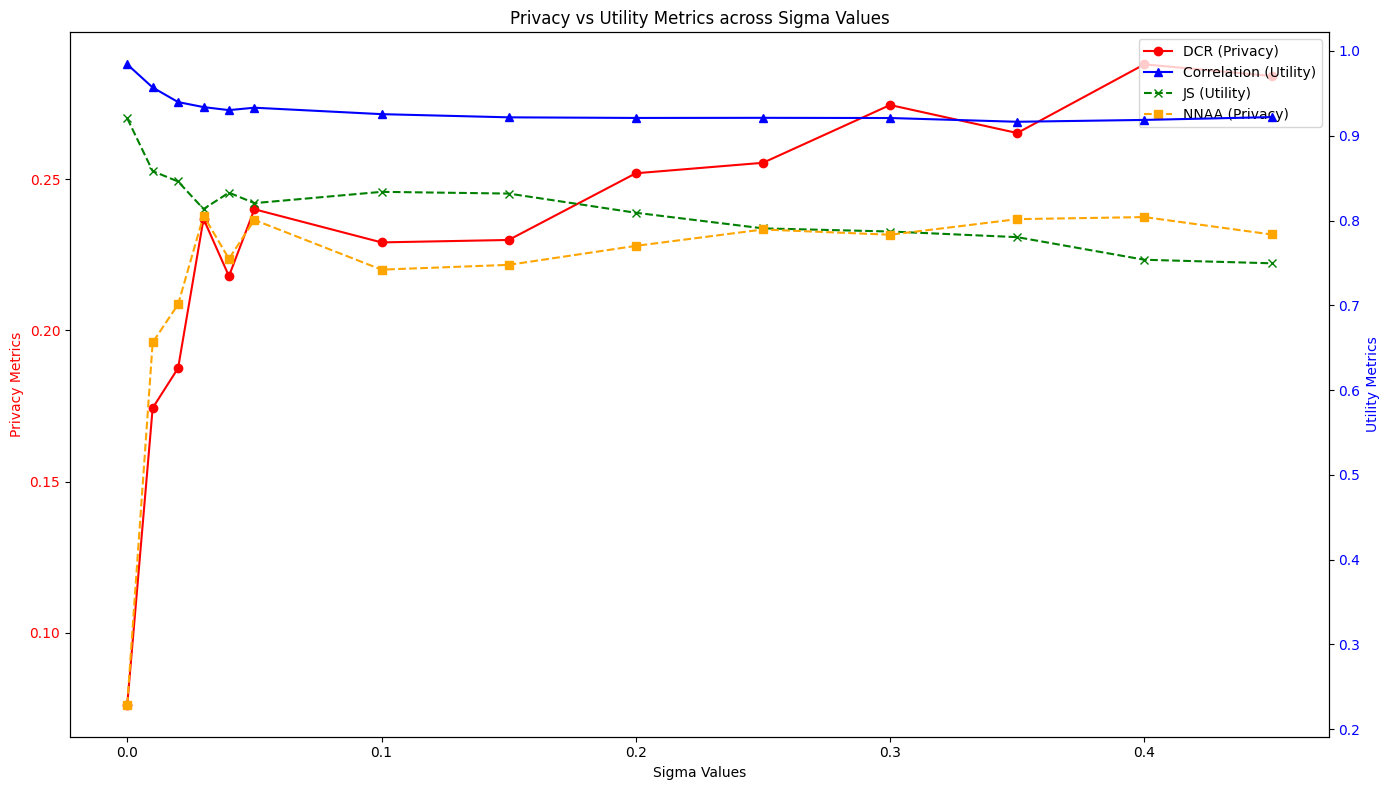

In [16]:
import matplotlib.pyplot as plt

datasets = df["sigma"]

DCR = df["DCR"]
adversarial_accuracy = df["NNAA"]

correlation = df["Correlation"]
JS = df["JS"]

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(datasets, DCR, marker='o', color='red', label="DCR (Privacy)", linestyle='-')
ax1.set_xlabel("Sigma Values")
ax1.set_ylabel("Privacy Metrics", color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(datasets, correlation, marker='^', color='blue', label="Correlation (Utility)", linestyle='-')
ax2.plot(datasets, JS, marker='x', color='green', label="JS (Utility)", linestyle='--')
ax2.plot(datasets, adversarial_accuracy, marker='s', color='orange', label="NNAA (Privacy)", linestyle='--')
ax2.set_ylabel("Utility Metrics", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Privacy vs Utility Metrics across Sigma Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### remove

In [17]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.utility_metric_manager import UtilityMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.basic_stats import BasicStatsCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.mutual_information import MICalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.correlation import CorrelationCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.utility_metrics.statistical.js_similarity import JSCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.privacy_metric_manager import PrivacyMetricManager
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.adversarial_accuracy_class import AdversarialAccuracyCalculator, AdversarialAccuracyCalculator_NN
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.dcr_class import DCRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.nndr_class import NNDRCalculator
from privacy_utility_framework.privacy_utility_framework.metrics.privacy_metrics.distance.disco import DisclosureCalculator

# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/diabetes.csv")
original_name = "Insurance"

# Directory containing synthetic datasets
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/diabetes_syn_data"

# Dictionary to store aggregated results
aggregated_results = defaultdict(lambda: defaultdict(list))

# Function to extract sigma value as float
def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
    return None


# Loop through each synthetic file and perform calculations
for file_name in os.listdir(synthetic_folder):
    if file_name.endswith(".csv"):
        synthetic_path = os.path.join(synthetic_folder, file_name)
        synthetic_data = pd.read_csv(synthetic_path)
        # synthetic_data = replace_outliers_with_mean(original_data, synthetic_data)
        synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, file_name)
        # Ensure correct data types (e.g., convert 'age' column to int if needed)
        # if 'Glucose' in synthetic_data.columns:
        #     synthetic_data['Glucose'] = synthetic_data['Glucose'].astype(int)
        # if 'BloodPressure' in synthetic_data.columns:
        #     synthetic_data['BloodPressure'] = synthetic_data['BloodPressure'].astype(int)
        for column in synthetic_data.columns:
            if column in original_data.columns:
                # Convert the column type in synthetic data to match the original data
                synthetic_data[column] = synthetic_data[column].astype(original_data[column].dtype)


        sigma = extract_sigma(file_name)
        if sigma is None:
            continue  # Skip files without a valid sigma value
        # print(f"\nProcessing synthetic dataset: {file_name} (sigma: {sigma})")

        # Utility Metric Calculation
        u = UtilityMetricManager()
        utility_metric_list = [
            BasicStatsCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            MICalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            CorrelationCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            JSCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        u.add_metric(utility_metric_list)
        results_utility = u.evaluate_all()

        # Privacy Metric Calculation
        p = PrivacyMetricManager()
        privacy_metric_list = [
            DCRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            NNDRCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator_NN(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
            AdversarialAccuracyCalculator(original_data, synthetic_data, original_name=original_name, synthetic_name=file_name),
        ]
        p.add_metric(privacy_metric_list)
        results_privacy = p.evaluate_all()

        # # DiSCO and repU
        diabetes_keys = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
        diabetes_target = 'Outcome'  

        calc = DisclosureCalculator(original_data, synthetic_data, keys=diabetes_keys, target=diabetes_target)
        repU, DiSCO = calc.evaluate()

        # Aggregate metrics
        for key, value in {**results_utility, **results_privacy}.items():
            aggregated_results[sigma][key].append(value)


        aggregated_results[sigma]["Disclosure_repU"].append(repU)
        aggregated_results[sigma]["Disclosure_DiSCO"].append(DiSCO)

# Calculate average metrics for each sigma
averaged_results = defaultdict(dict)
for sigma, metrics in aggregated_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):
            averaged_results[sigma][metric] = {k: np.mean([v[k] for v in values]) for k in values[0]}
        else:
            averaged_results[sigma][metric] = np.mean(values)

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 152.98it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1087 columns.
IDENTITY: 
     UiO        UiS     UiOiS      repU
0  100.0  74.529667  35.15625  25.78125
ATTRIBUTES: 
   Dorig       Dsyn        iS        DiS      DiSCO     DiSDiO  max_denom  \
0  100.0  92.908828  35.15625  32.682292  28.385417  28.385417        1.0   

   mean_denom  
0         1.0  
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 148.37it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1459 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 143.74it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1451 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-010.csv, removed 17 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 141.04it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1435 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-015.csv, removed 33 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 139.30it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1421 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 142.57it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1396 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 145.57it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1379 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-030.csv, removed 66 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 141.55it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1362 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-035.csv, removed 73 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 153.31it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1332 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-040.csv, removed 68 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 165.91it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1335 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-045.csv, removed 81 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 147.36it/s]


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1305 columns.


/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 137.37it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1441 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-002.csv, removed 3 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 137.57it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1455 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-003.csv, removed 2 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 148.92it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1455 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~
Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Method CorrelationMethod.PEARSON was used.


100%|██████████| 4/4 [00:00<00:00, 150.96it/s]
/content/drive/MyDrive/Colab Notebooks/synprivutil-main/privacy_utility_framework/privacy_utility_framework/metrics/privacy_metrics/distance/disco.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syndata[j][col] = syndata[j][col].astype('category')


Synthetic and original data checked with synorig.compare,
 looks like no adjustment needed


-------------------Synthesis 1--------------------
Table for target Outcome from GT alone with keys has 2 rows and 768 columns.
Table for target Outcome from GT & SD with all key combinations has 2 rows and 1454 columns.
IDENTITY: 
     UiO    UiS  UiOiS  repU
0  100.0  100.0    0.0   0.0
ATTRIBUTES: 
   Dorig   Dsyn   iS  DiS  DiSCO  DiSDiO  max_denom  mean_denom
0  100.0  100.0  0.0  0.0    0.0     0.0        0.0         NaN
~~~~~~~~~~~~~~~ Done ~~~~~~~~~~~~~~~


In [18]:
# Clean up averaged_results to extract metric names without file details
cleaned_results = defaultdict(dict)

for sigma, metrics in averaged_results.items():
    for metric, value in metrics.items():
        # Extract only the metric name, ignoring dataset/file info
        metric_name = metric.split("(")[0]
        if metric_name not in cleaned_results[sigma]:
            cleaned_results[sigma][metric_name] = []
        cleaned_results[sigma][metric_name].append(value)

# Aggregate and calculate average values for cleaned results
final_results = defaultdict(dict)
for sigma, metrics in cleaned_results.items():
    for metric, values in metrics.items():
        if isinstance(values[0], dict):  # If metric value is a dictionary
            # Average each key in the dictionary
            final_results[sigma][metric] = {k: sum(v[k] for v in values) / len(values) for k in values[0]}
        else:  # If metric value is a list of scalars
            final_results[sigma][metric] = sum(values) / len(values)

# Prepare data for plotting
data = {
    "sigma": sorted(final_results.keys()),
    "DCR": [final_results[sigma].get("DCRCalculator", None) for sigma in sorted(final_results.keys())],
    "NNDR": [final_results[sigma].get("NNDRCalculator", None) for sigma in sorted(final_results.keys())],
    # "AdversarialAccuracy": [final_results[sigma].get("AdversarialAccuracyCalculator", None) for sigma in sorted(final_results.keys())],
    "NNAA": [final_results[sigma].get("AdversarialAccuracyCalculator_NN", None) for sigma in sorted(final_results.keys())],
    "Correlation": [final_results[sigma].get("CorrelationCalculator", None) for sigma in sorted(final_results.keys())],
    "JS": [final_results[sigma].get("JSCalculator", None) for sigma in sorted(final_results.keys())],
    "repU": [final_results[sigma].get("Disclosure_repU", None) for sigma in sorted(final_results.keys())],
    "DiSCO": [final_results[sigma].get("Disclosure_DiSCO", None) for sigma in sorted(final_results.keys())],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Verify DataFrame content
print(df)


    sigma       DCR      NNDR      NNAA  Correlation        JS      repU  \
0    0.00  0.076270  0.395513  0.228899     0.984228  0.920506  25.78125   
1    0.01  0.174328  0.852604  0.656199     0.956929  0.858296   0.00000   
2    0.02  0.187581  0.854090  0.701135     0.939778  0.846426   0.00000   
3    0.03  0.236946  0.867247  0.805430     0.933764  0.813484   0.00000   
4    0.04  0.218237  0.865142  0.754929     0.930212  0.832818   0.00000   
5    0.05  0.240084  0.869539  0.800752     0.932905  0.820439   0.00000   
6    0.10  0.230021  0.867427  0.743304     0.925113  0.833089   0.00000   
7    0.15  0.229685  0.869621  0.744643     0.921410  0.832124   0.00000   
8    0.20  0.252528  0.865175  0.769303     0.920883  0.808437   0.00000   
9    0.25  0.257545  0.876966  0.783744     0.920977  0.791890   0.00000   
10   0.30  0.275887  0.873286  0.780125     0.921656  0.785389   0.00000   
11   0.35  0.264305  0.881280  0.790268     0.916003  0.782888   0.00000   
12   0.40  0

In [19]:

basic_stats_data = {
    "sigma": [],
    "mean": [],
    "median": [],
    "var": []
}

for sigma, metrics in final_results.items():
    if "BasicStatsCalculator" in metrics:
        basic_stats = metrics["BasicStatsCalculator"]
        basic_stats_data["sigma"].append(sigma)
        basic_stats_data["mean"].append(basic_stats["mean"])
        basic_stats_data["median"].append(basic_stats["median"])
        basic_stats_data["var"].append(basic_stats["var"])

basic_stats_df = pd.DataFrame(basic_stats_data)

print(basic_stats_df)


    sigma      mean    median       var
0    0.00  0.017840  0.019283  0.003327
1    0.01  0.040195  0.051677  0.007280
2    0.05  0.052168  0.080625  0.012078
3    0.10  0.037525  0.050698  0.012206
4    0.15  0.047495  0.058126  0.010191
5    0.20  0.041840  0.048185  0.015305
6    0.25  0.047786  0.047977  0.013769
7    0.30  0.046243  0.025514  0.019129
8    0.35  0.045398  0.042192  0.014094
9    0.40  0.051140  0.054031  0.021968
10   0.45  0.055837  0.062369  0.013905
11   0.02  0.042122  0.051657  0.006643
12   0.03  0.054074  0.082809  0.011762
13   0.04  0.035381  0.048015  0.010484


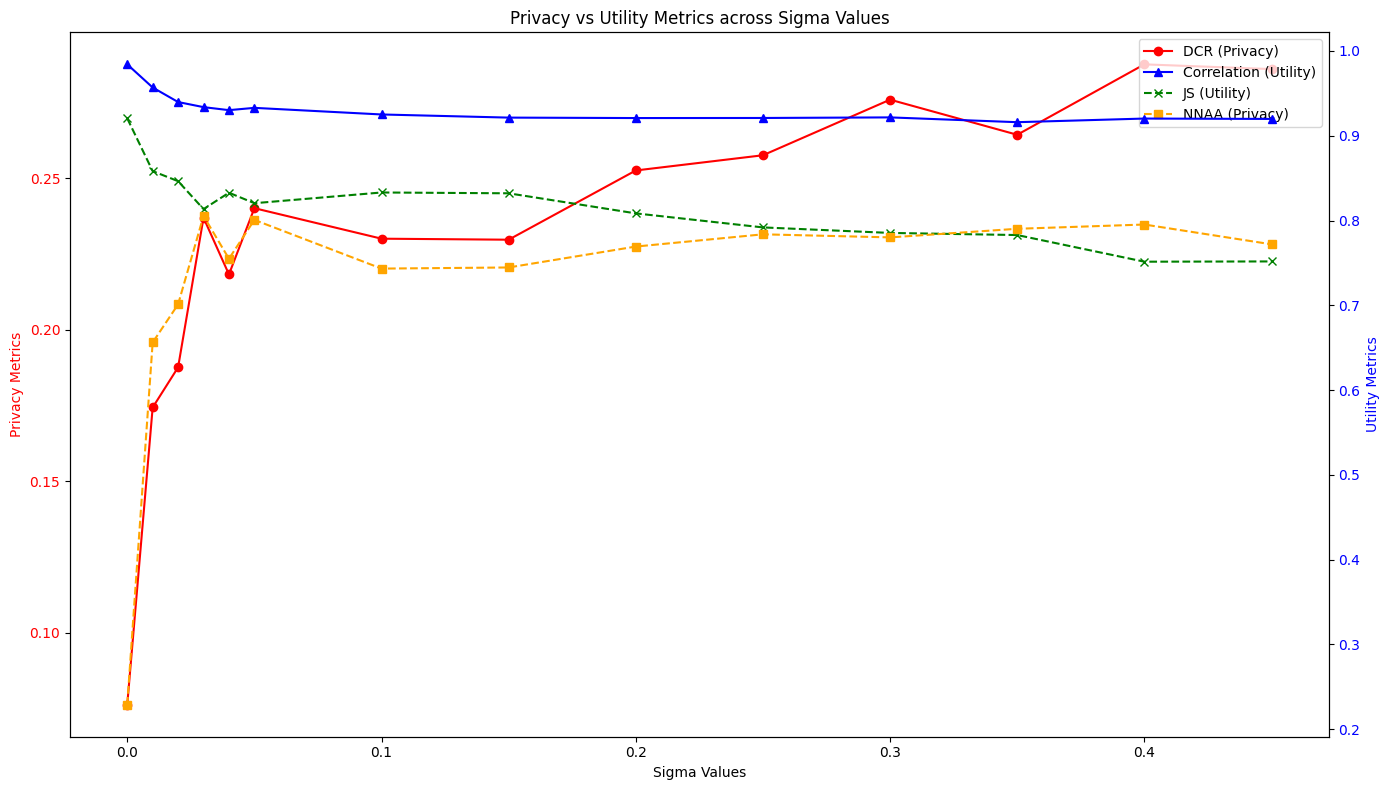

In [20]:
import matplotlib.pyplot as plt

datasets = df["sigma"]

DCR = df["DCR"]
adversarial_accuracy = df["NNAA"]

correlation = df["Correlation"]
JS = df["JS"]

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(datasets, DCR, marker='o', color='red', label="DCR (Privacy)", linestyle='-')
ax1.set_xlabel("Sigma Values")
ax1.set_ylabel("Privacy Metrics", color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(datasets, correlation, marker='^', color='blue', label="Correlation (Utility)", linestyle='-')
ax2.plot(datasets, JS, marker='x', color='green', label="JS (Utility)", linestyle='--')
ax2.plot(datasets, adversarial_accuracy, marker='s', color='orange', label="NNAA (Privacy)", linestyle='--')
ax2.set_ylabel("Utility Metrics", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title("Privacy vs Utility Metrics across Sigma Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Comparison

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Under diabetes-sigma-002.csv, removed 3 rows with outliers.
Under diabetes-sigma-003.csv, removed 2 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Under diabetes-sigma-010.csv, removed 17 rows with outliers.
Under diabetes-sigma-015.csv, removed 33 rows with outliers.
Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Under diabetes-sigma-030.csv, removed 66 rows with outliers.
Under diabetes-sigma-035.csv, removed 73 rows with outliers.
Under diabetes-sigma-040.csv, removed 68 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-045.csv, removed 81 rows with outliers.


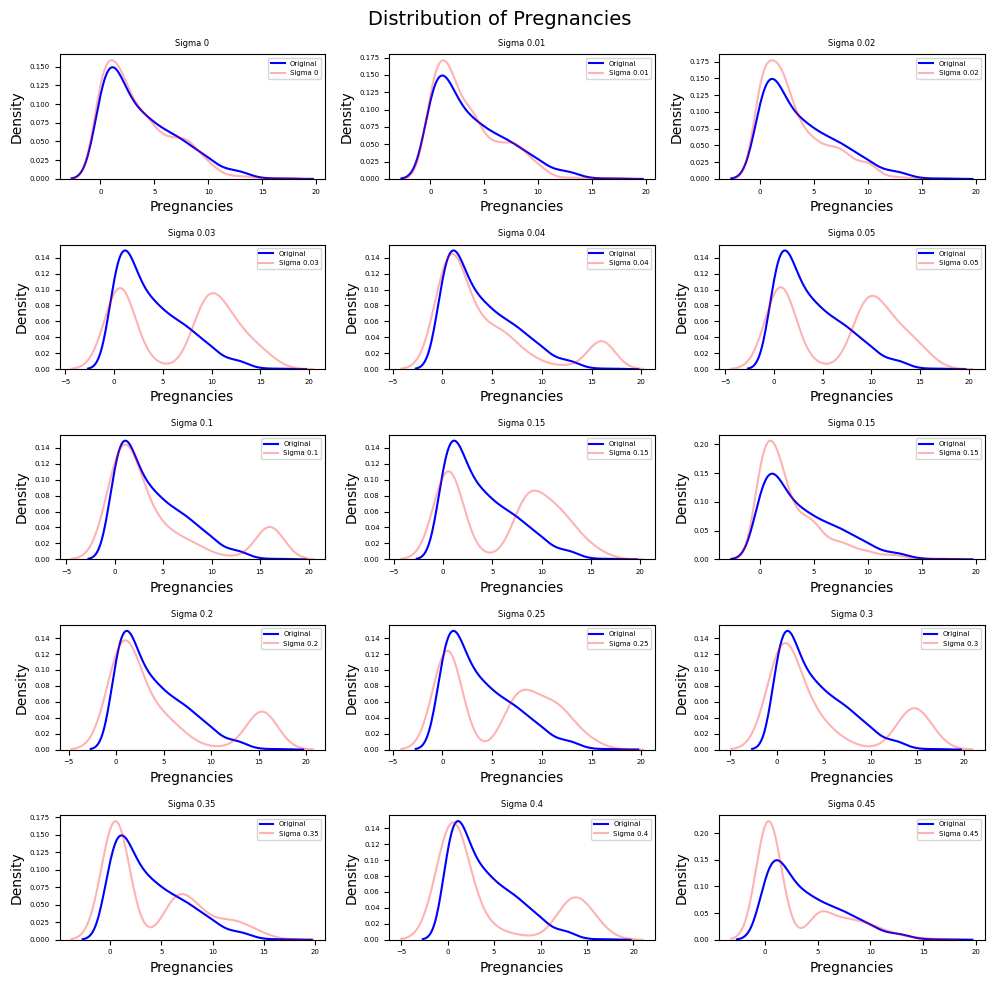

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Under diabetes-sigma-002.csv, removed 3 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-003.csv, removed 2 rows with outliers.
Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Under diabetes-sigma-010.csv, removed 17 rows with outliers.
Under diabetes-sigma-015.csv, removed 33 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.
Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Under diabetes-sigma-030.csv, removed 66 rows with outliers.
Under diabetes-sigma-035.csv, removed 73 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-040.csv, removed 68 rows with outliers.
Under diabetes-sigma-045.csv, removed 81 rows with outliers.


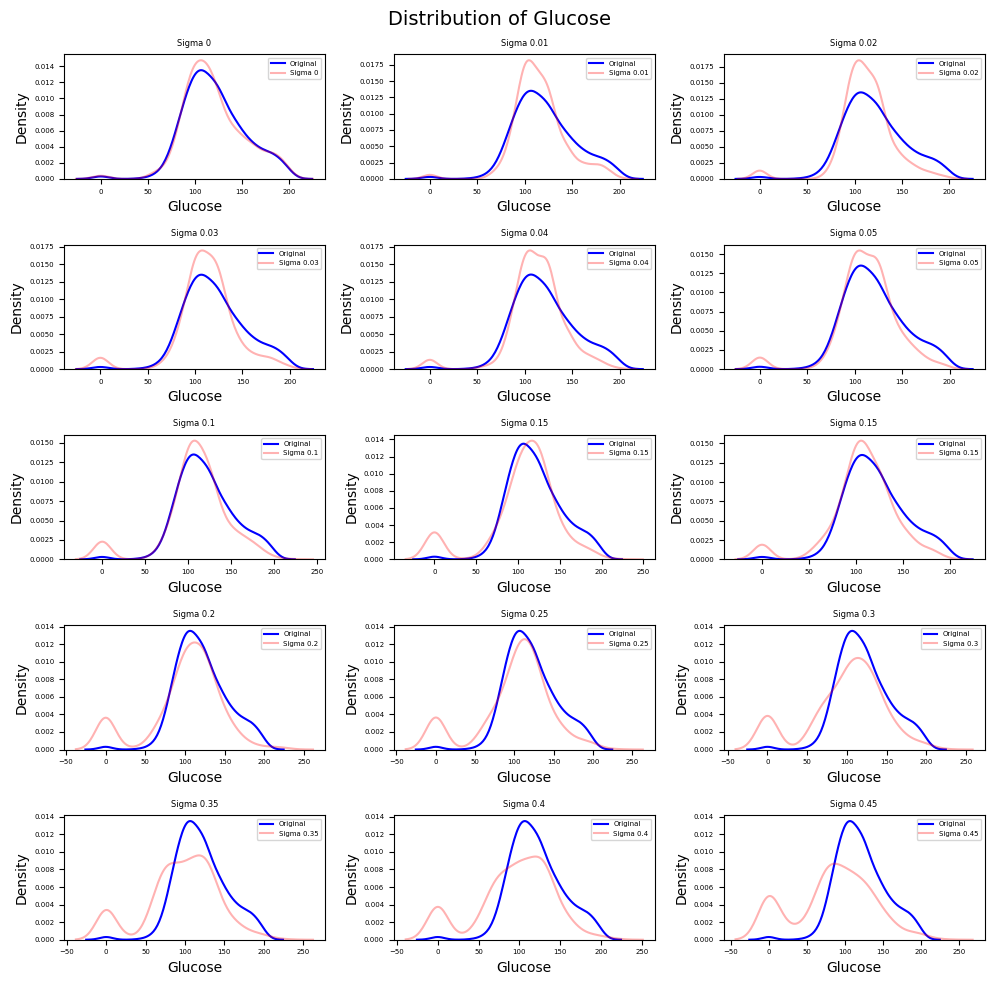

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Under diabetes-sigma-002.csv, removed 3 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-003.csv, removed 2 rows with outliers.
Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Under diabetes-sigma-010.csv, removed 17 rows with outliers.
Under diabetes-sigma-015.csv, removed 33 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.
Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Under diabetes-sigma-030.csv, removed 66 rows with outliers.
Under diabetes-sigma-035.csv, removed 73 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-040.csv, removed 68 rows with outliers.
Under diabetes-sigma-045.csv, removed 81 rows with outliers.


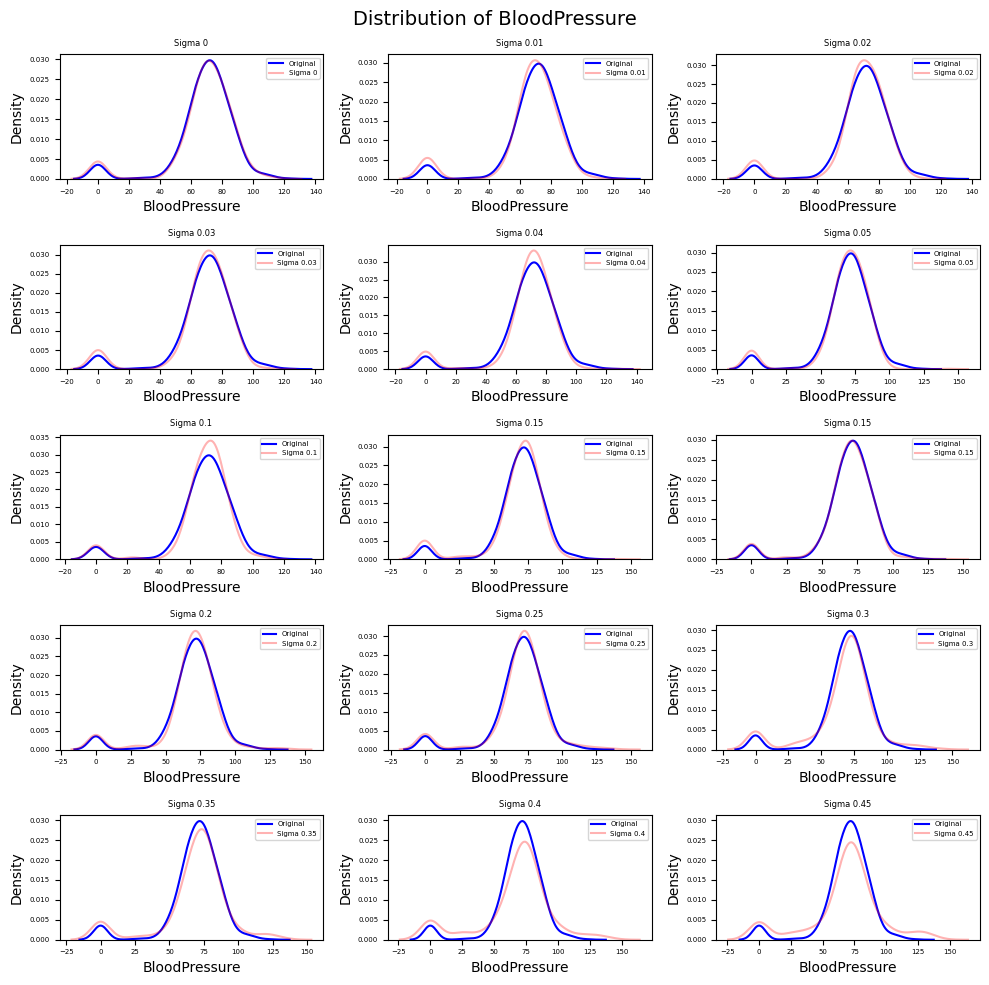

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Under diabetes-sigma-002.csv, removed 3 rows with outliers.
Under diabetes-sigma-003.csv, removed 2 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Under diabetes-sigma-010.csv, removed 17 rows with outliers.
Under diabetes-sigma-015.csv, removed 33 rows with outliers.
Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Under diabetes-sigma-030.csv, removed 66 rows with outliers.
Under diabetes-sigma-035.csv, removed 73 rows with outliers.
Under diabetes-sigma-040.csv, removed 68 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Under diabetes-sigma-045.csv, removed 81 rows with outliers.


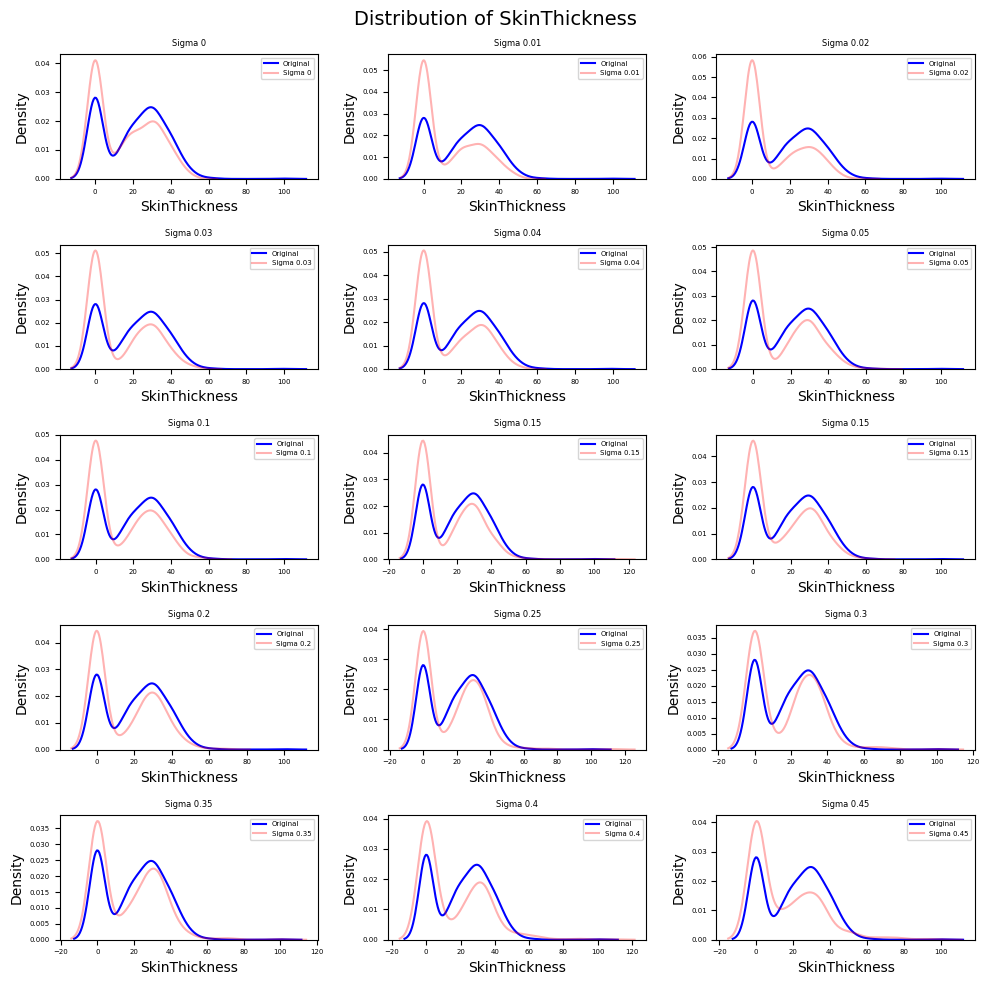

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Under diabetes-sigma-002.csv, removed 3 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-003.csv, removed 2 rows with outliers.
Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Under diabetes-sigma-010.csv, removed 17 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-015.csv, removed 33 rows with outliers.
Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.
Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Under diabetes-sigma-030.csv, removed 66 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-035.csv, removed 73 rows with outliers.
Under diabetes-sigma-040.csv, removed 68 rows with outliers.
Under diabetes-sigma-045.csv, removed 81 rows with outliers.


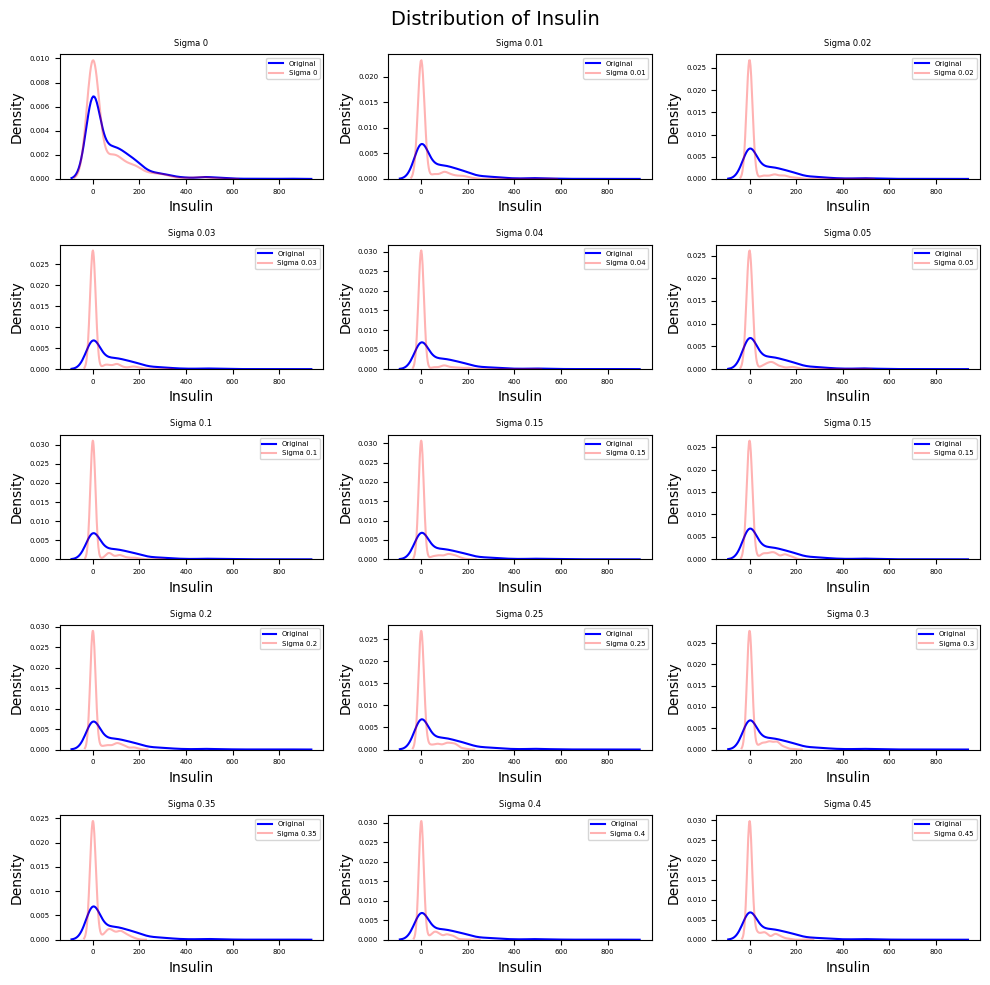

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Under diabetes-sigma-002.csv, removed 3 rows with outliers.
Under diabetes-sigma-003.csv, removed 2 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Under diabetes-sigma-010.csv, removed 17 rows with outliers.
Under diabetes-sigma-015.csv, removed 33 rows with outliers.
Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Under diabetes-sigma-030.csv, removed 66 rows with outliers.
Under diabetes-sigma-035.csv, removed 73 rows with outliers.
Under diabetes-sigma-040.csv, removed 68 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-045.csv, removed 81 rows with outliers.


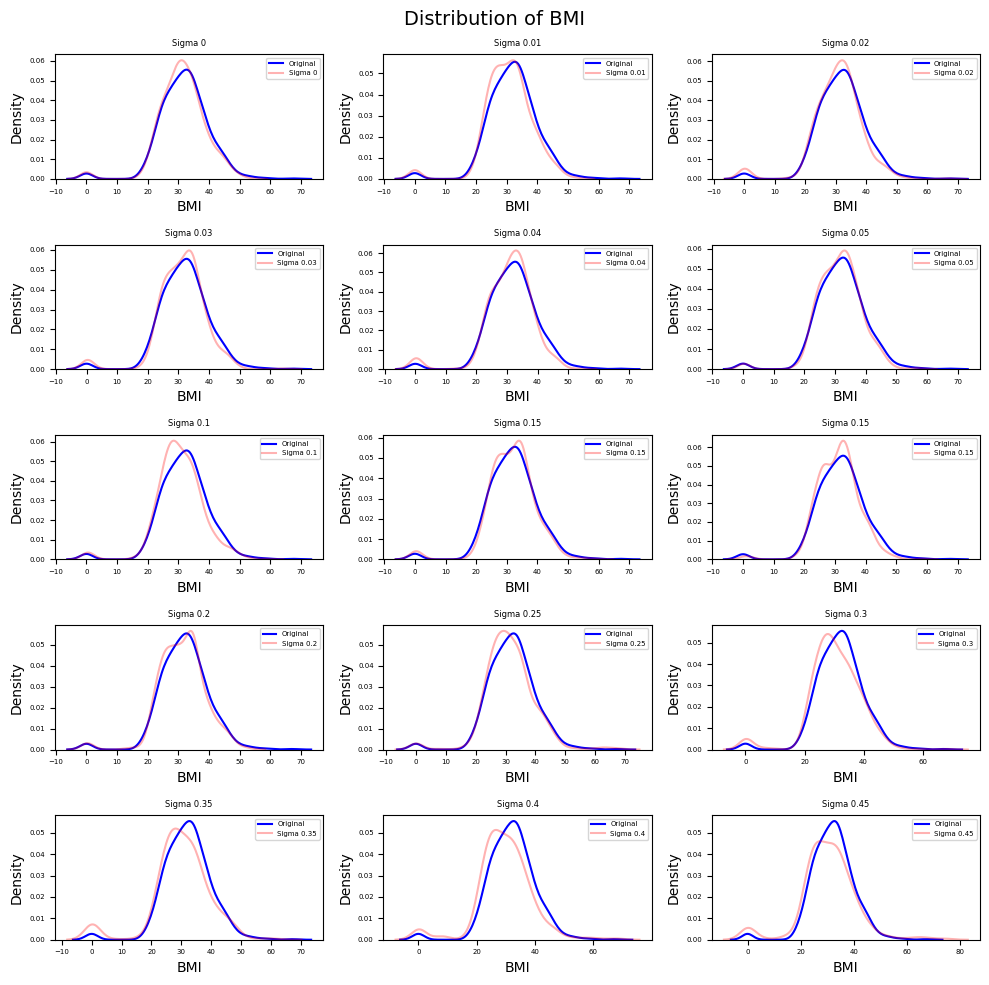

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Under diabetes-sigma-002.csv, removed 3 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-003.csv, removed 2 rows with outliers.
Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Under diabetes-sigma-010.csv, removed 17 rows with outliers.
Under diabetes-sigma-015.csv, removed 33 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.
Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Under diabetes-sigma-030.csv, removed 66 rows with outliers.
Under diabetes-sigma-035.csv, removed 73 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-040.csv, removed 68 rows with outliers.
Under diabetes-sigma-045.csv, removed 81 rows with outliers.


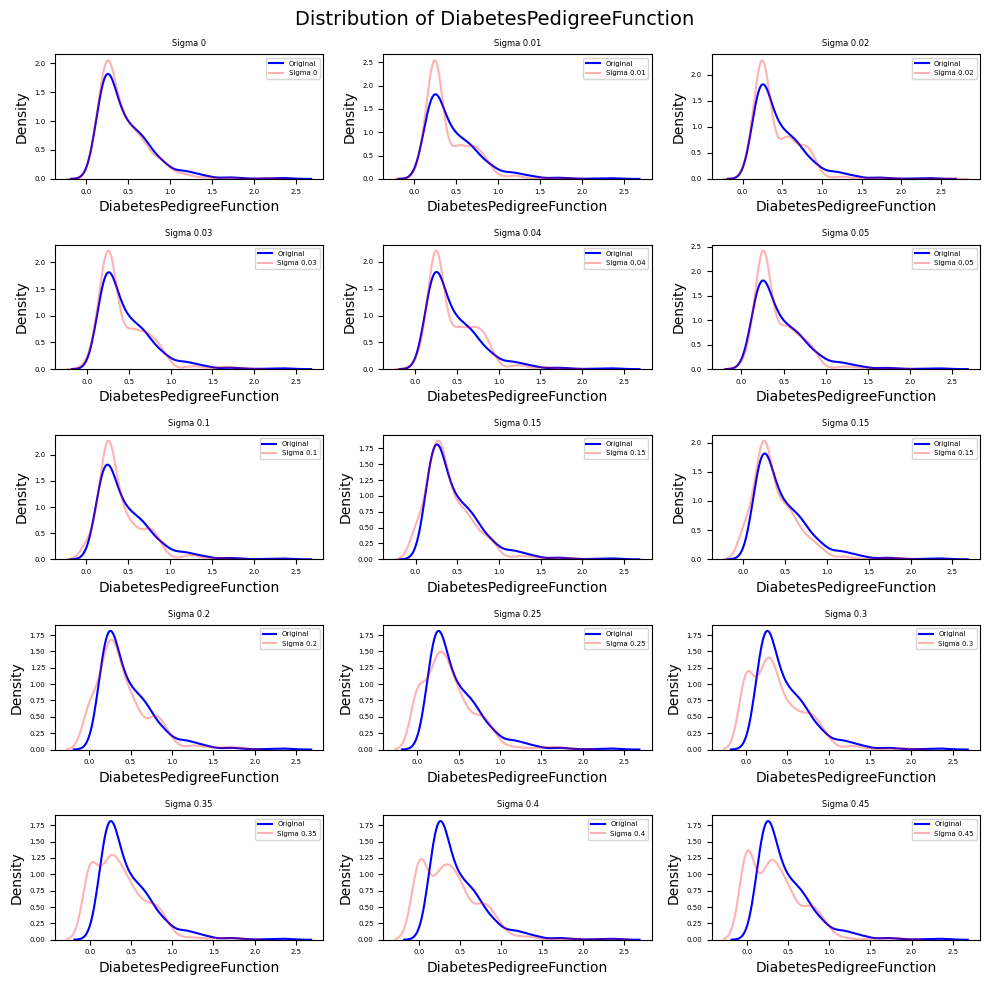

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Under diabetes-sigma-002.csv, removed 3 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-003.csv, removed 2 rows with outliers.
Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Under diabetes-sigma-010.csv, removed 17 rows with outliers.
Under diabetes-sigma-015.csv, removed 33 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.
Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Under diabetes-sigma-030.csv, removed 66 rows with outliers.
Under diabetes-sigma-035.csv, removed 73 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-040.csv, removed 68 rows with outliers.
Under diabetes-sigma-045.csv, removed 81 rows with outliers.


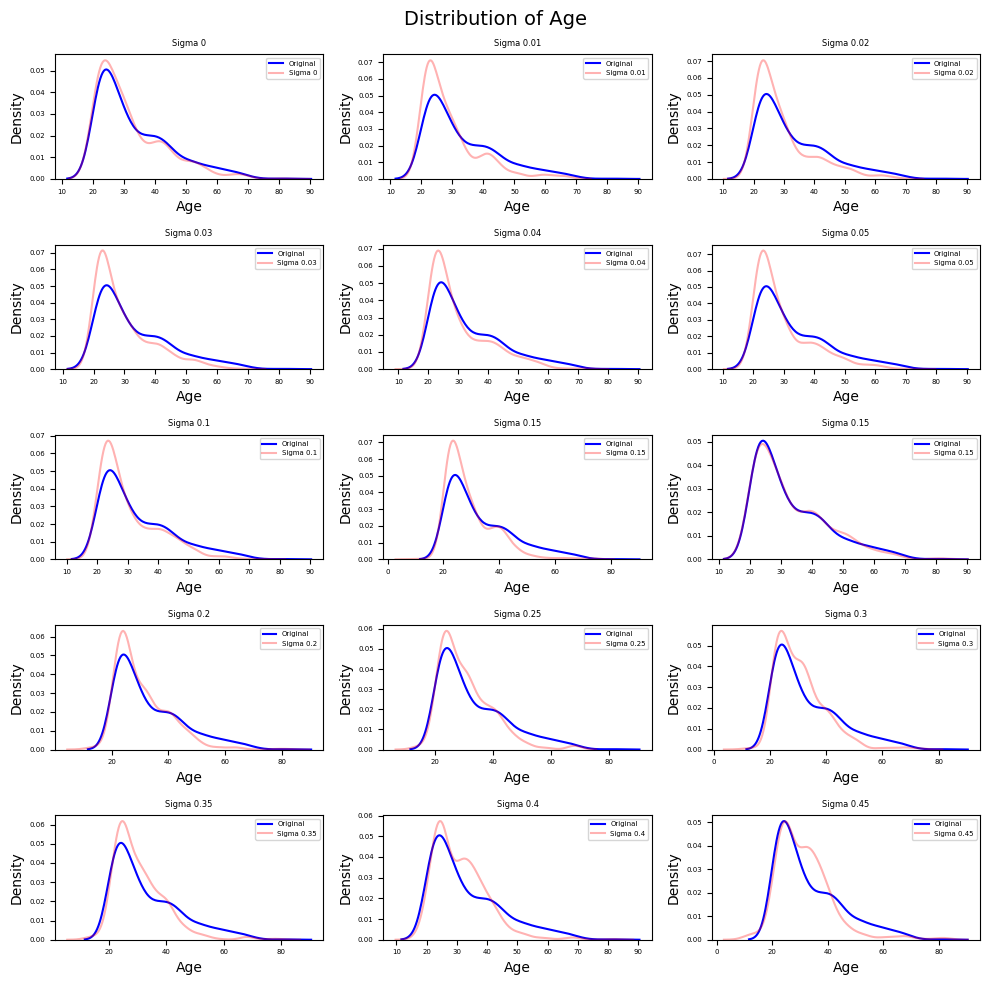

Under diabetes-sigma-0.csv, removed 0 rows with outliers.
Under diabetes-sigma-001.csv, removed 0 rows with outliers.
Under diabetes-sigma-002.csv, removed 3 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-003.csv, removed 2 rows with outliers.
Under diabetes-sigma-004.csv, removed 3 rows with outliers.
Under diabetes-sigma-005.csv, removed 4 rows with outliers.
Under diabetes-sigma-010.csv, removed 17 rows with outliers.
Under diabetes-sigma-015.csv, removed 33 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-switch-sigma-015.csv, removed 6 rows with outliers.
Under diabetes-sigma-020.csv, removed 36 rows with outliers.
Under diabetes-sigma-025.csv, removed 56 rows with outliers.
Under diabetes-sigma-030.csv, removed 66 rows with outliers.
Under diabetes-sigma-035.csv, removed 73 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Under diabetes-sigma-040.csv, removed 68 rows with outliers.
Under diabetes-sigma-045.csv, removed 81 rows with outliers.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


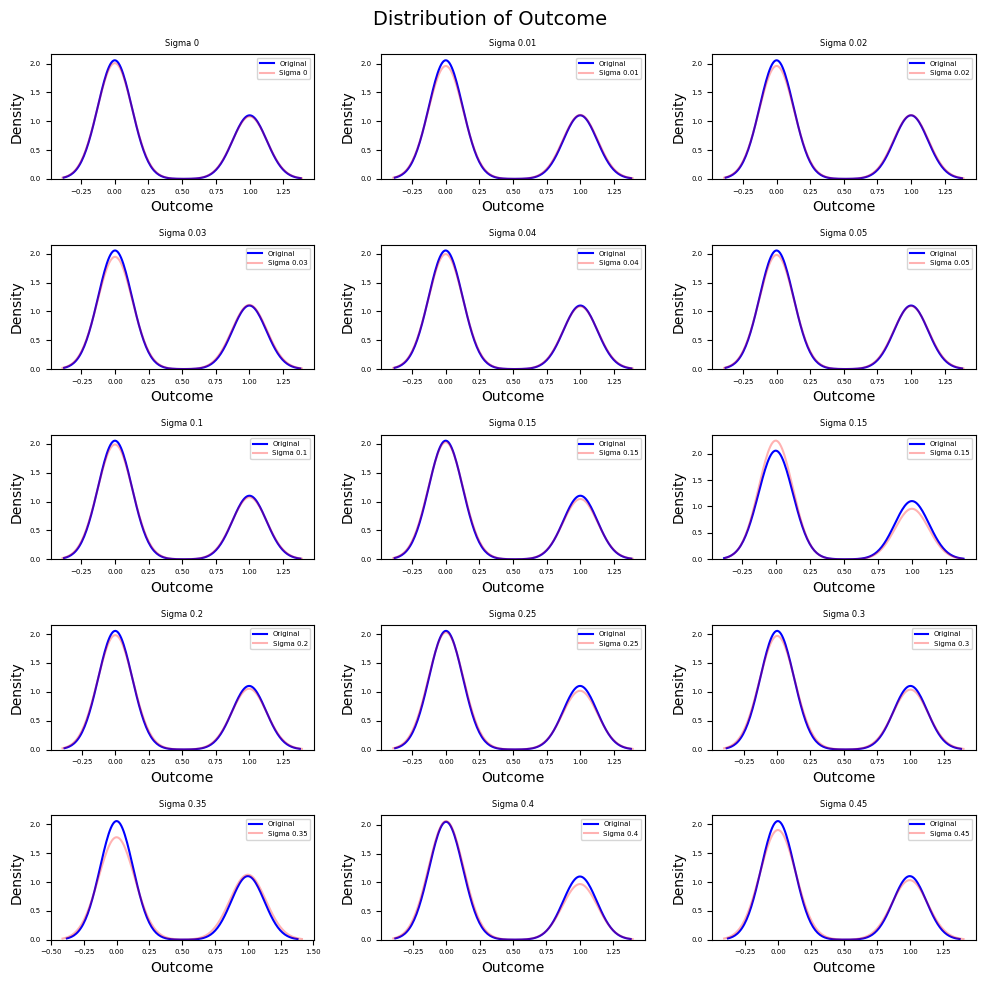

In [42]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_sigma(file_name):
    match = re.search(r"sigma-(\d+)", file_name)
    if match:
        sigma_str = match.group(1)
        if len(sigma_str) == 1:  # Single digit like "1" -> "1"
            return int(sigma_str)
        elif len(sigma_str) == 2:  # Two digits like "05" -> "0.5"
            return int(sigma_str) / 10
        elif len(sigma_str) == 3:  # Three digits like "005" -> "0.05"
            return int(sigma_str) / 100
    return None



def plot_comparison_for_each_column(original_data, synthetic_folder):
    """
    For each column, plot synthetic data with different sigma values against original data.
    """
    synthetic_files = [
        (file_name, extract_sigma(file_name))
        for file_name in os.listdir(synthetic_folder)
        if file_name.endswith(".csv") and extract_sigma(file_name) is not None
    ]

    # Sort files by sigma
    synthetic_files = sorted(synthetic_files, key=lambda x: x[1])

    # Iterate over each column
    for column in original_data.columns:
        # Adjust the number of rows and columns in the subplot grid
        num_files = len(synthetic_files)
        ncols = 3
        nrows = (num_files + ncols - 1) // ncols  # Ceiling division for rows

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 2 * nrows))

        # Flatten axes array for easy indexing
        axes = axes.flatten()

        for i, (file_name, sigma) in enumerate(synthetic_files):
            synthetic_path = os.path.join(synthetic_folder, file_name)
            synthetic_data = pd.read_csv(synthetic_path)
            # synthetic_data = replace_outliers_with_mean(original_data, synthetic_data)
            synthetic_data = remove_rows_with_outliers(original_data, synthetic_data, file_name)
            # Plot original and synthetic distributions
            sns.kdeplot(original_data[column], ax=axes[i], label='Original', color='blue')
            if column in synthetic_data.columns:
                sns.kdeplot(synthetic_data[column], ax=axes[i], label=f'Sigma {sigma}', color='red', alpha=0.3)

            axes[i].set_title(f'Sigma {sigma}', fontsize=6)
            axes[i].legend(fontsize=5)
            axes[i].tick_params(axis='both', which='major', labelsize=5)

        # Hide unused subplots
        for j in range(len(synthetic_files), len(axes)):
            axes[j].axis('off')

        fig.suptitle(f'Distribution of {column}', fontsize=14)
        plt.tight_layout()
        plt.show()



# Load original dataset
original_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/Real_Datasets/diabetes.csv")

# Path to synthetic datasets folder
synthetic_folder = "/content/drive/MyDrive/Colab Notebooks/Tabula-main-claude/diabetes_syn_data"

# Generate plots
plot_comparison_for_each_column(original_data, synthetic_folder)
